## Background / Motivation (Luna + Kiara)

What motivated you to work on this problem?

Mention any background about the problem, if it is required to understand your analysis later on.

Many hotels usually only charge a small price or allow customers to cancel their hotel booking completely free. However, this can lead to a problem for the hotel if customers abuse this service. Therefore, one solution is to overbook the hotel, but overbooking runs the risk of upsetting customers if they end up not getting a room. This also might result in the hotel having to book their customer a room in a different hotel, leading to an even higher cost. 

## Problem statement (Luna + Kiara)

Describe your problem statement. Articulate your objectives using absolutely no jargon. Interpret the problem as inference and/or prediction.

Predicting the probability of cancellation of each customer to develop an overbooking formula is very helpful to determine the number of rooms to overbook and therefore, maximimizes profit. 

## Data sources (Luna + Kiara)
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

We pull a hotel reservation dataset from Kaggle with around 36,000 observations and 18 variables. Here is the link to the dataset: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## Stakeholders (Luna + Kiara)
Who cares? If you are successful, what difference will it make to them?

The hotel manager and the INN hotel chain are our stakeholders. For the hotel manager, they would be able to identify the probability of a customer cancelling their reservation to navigate overbooking. On the other hand, the INN hotel chain cares because they want to maximizes their profit by minimizing the loss from having empty rooms in the hotel.

## Data quality check / cleaning / preparation (Hoda, Elena)

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

If the tables in this section take too much space, you may put them in the appendix, and just mention any useful insights you obtained from the data quality check that helped you develop the model or helped you realize the necessary data cleaning / preparation.

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did you do any data wrangling or data preparation before the data was ready to use for model development? Did you create any new predictors from exisiting predictors? For example, if you have number of transactions and spend in a credit card dataset, you may create spend per transaction for predicting if a customer pays their credit card bill. Mention the steps at a broad level, you may put minor details in the appendix. Only mention the steps that ended up being useful towards developing your final model(s).

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import itertools
import time
from datetime import datetime

In [5]:
# reading the hotel reservation dataset and identifying the number of missing values
hotels = pd.read_csv('Hotel Reservations.csv')
print('There are', hotels.isnull().sum().sum(), 'missing values in the hotel reservation dataset.')

There are 0 missing values in the hotel reservation dataset.


In [9]:
hotels.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [10]:
hotels.type_of_meal_plan.value_counts()

Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

In [12]:
hotels.room_type_reserved.value_counts()

Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

In [13]:
hotels.market_segment_type.value_counts()

Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

In [20]:
hotels.booking_status.value_counts()

0    24390
1    11885
Name: booking_status, dtype: int64

In [21]:
# Mapping response to 0 (Not Canceled) and 1 (Canceled) so we can use the information in a logistic regression
hotels['booking_status'].replace(['Canceled', 'Not_Canceled'],[1, 0], inplace=True)

In [22]:
# Split train and test datasets (75% of the data is used for training while the other 25% is used for testing)
y = hotels.booking_status
X = hotels.drop('booking_status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True, stratify=y)
train, test = train_test_split(hotels, test_size=0.25, random_state=25, shuffle=True, stratify=y)

In [23]:
# Checking for the number of reservations cancelled and not cancelled every month
monthly_cancel = hotels.groupby(hotels.arrival_month).booking_status.value_counts()

# Creating a dataframe with the number of reservations cancelled and not cancelled for every month
monthly_cancel = pd.DataFrame({'Did not cancel': [990, 1274, 1658, 1741, 1650, 1912, 1606, 2325, 3073, 3437, 2105, 2619],
                   'Cancelled': [24, 430, 700, 995, 948, 1291, 1314, 1488, 1538, 1880, 875, 402]}, 
                  index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

In [24]:
# Create a dataframe wiht the percentage of reservations cancelled and not cancelled for every month
monthly_cancel_percent = monthly_cancel.copy()
monthly_cancel_percent['Total'] = monthly_cancel_percent['Did not cancel'] + monthly_cancel_percent['Cancelled']
monthly_cancel_percent['Did not cancel percent'] = monthly_cancel_percent['Did not cancel']/monthly_cancel_percent['Total']
monthly_cancel_percent['Cancel percent'] = monthly_cancel_percent['Cancelled']/monthly_cancel_percent['Total']
monthly_cancel_percent = monthly_cancel_percent.drop(['Did not cancel', 'Cancelled', 'Total'], axis = 1)

## Exploratory data analysis (Hoda, Elena)

Put the relevant EDA here (visualizations, tables, etc.) that helped you figure out useful predictors for developing the model(s). Only put the EDA that ended up being useful towards developing your final model(s). 

List the insights (as bullet points) you got from EDA that ended up being useful towards developing your final model. 

Again, if there are too many plots / tables, you may put them into appendix, and just mention the insights you got from them.

### Autocorrelation attempts

Since logistic regression does not utilize residuals, we cannot really use autocorrelation. However, there might be some correlation between month with the number of cancellation, so we attempted to look into that relationship.

First, I want to look at the different months and see number of overall booking as well as the number of cancellation for each month

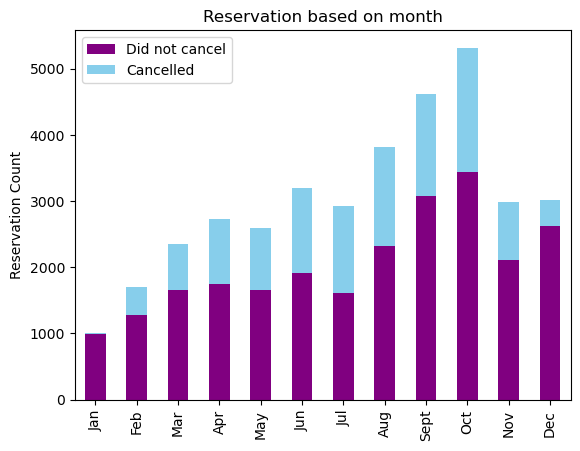

In [25]:
monthly_cancel.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Reservation Count")
plt.title("Reservation based on month")
plt.show()

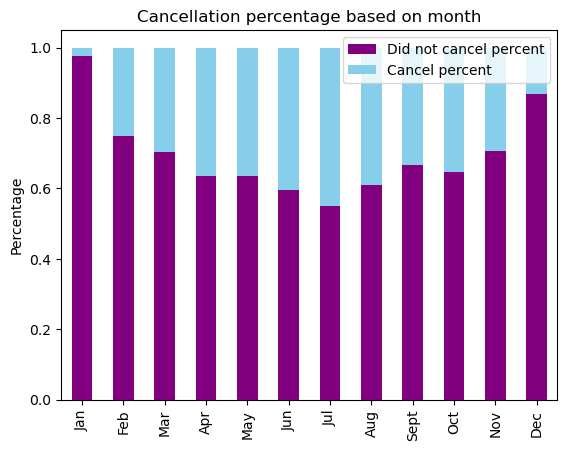

In [26]:
monthly_cancel_percent.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Percentage")
plt.title('Cancellation percentage based on month')
plt.show()

All of the months have a relatively similar rate of cancellation with the exception of January and December. July has a slightly higher rate of cancellation, but I don't think that it is too significant. Therefore, we can conclude that generally, even though there is a correlation between the totally number of reservations and the month of the year, there seems to be no correlation between the percentage of cancellation. 

## Approach (Elena)

What kind of a model (linear / logistic / other) did you use? What performance metric(s) did you optimize and why?

Is there anything unorthodox / new in your approach? 

What problems did you anticipate? What problems did you encounter? Did the very first model you tried work? 

Did your problem already have solution(s) (posted on Kaggle or elsewhere). If yes, then how did you build upon those solutions, what did you do differently? Is your model better as compared to those solutions in terms of prediction / inference?

**Important: Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.**

The models we developed were logistic being as this was a classification problem. Hotel guests either cancelled their hotel bookings (cancelled = 1) or did not cancel (not_cancelled = 0). We wanted to app

## Developing the model (Hoda, Elena)

Explain the steps taken to develop and improve the base model - informative visualizations / addressing modeling assumption violations / variable transformation / interactions / outlier treatment / influential points treatment / addressing over-fitting / addressing multicollinearity / variable selection - stepwise regression, lasso, ridge regression). 

Did you succeed in achieving your goal, or did you fail? Why?

**Put the final model equation**.

**Important: This section should be rigorous and thorough. Present detailed information about decision you made, why you made them, and any evidence/experimentation to back them up.**

In [ ]:
We first began the model development process using 

## Limitations of the model with regard to inference / prediction

If it is inference, will the inference hold for a certain period of time, for a certain subset of population, and / or for certain conditions.

If it is prediction, then will it be possible / convenient / expensive for the stakeholders to collect the data relating to the predictors in the model. Using your model, how soon will the stakeholder be able to predict the outcome before the outcome occurs. For example, if the model predicts the number of bikes people will rent in Evanston on a certain day, then how many days before that day will your model be able to make the prediction. This will depend on how soon the data that your model uses becomes available. If you are predicting election results, how many days / weeks / months / years before the election can you predict the results. 

When will your model become too obsolete to be useful?

## Developing Overbooking Formula (Luna + Kiara)

You are welcome to introduce additional sections or subsections, if required, to address any specific aspects of your project in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions and Recommendations to stakeholder(s) (Luna + Kiara)

What conclusions do you draw based on your model? If it is inference you may draw conclusions based on the coefficients, statistical significance of predictors / interactions, etc. If it is prediction, you may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

## GitHub and individual contribution {-}

**Github link**: https://github.com/LinhNgaNguyen/STAT303-2-Project

Add details of each team member's contribution in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;"> 
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Contributed aspects</th>
    <th>Details</th>
    <th>Number of GitHub commits</th>
  </tr>
  <tr>
    <td>Hoda Fakhari</td>
    <td>Data cleaning and EDA</td>
    <td>Cleaned data to impute missing values and developed visualizations to identify appropriate variable transformations.</td>
    <td>100</td>
  </tr>
  <tr>
    <td>Elena Llaguno Cantu</td>
    <td>Assumptions and interactions</td>
    <td>Checked and addressed modeling assumptions and identified relevant variable interactions.</td>
    <td>120</td>
  </tr>
    <tr>
    <td>Luna Nguyen</td>
    <td>Outlier and influential points treatment</td>
    <td>Identified outliers/influential points and analayzed their effect on the model.</td>
    <td>130</td>    
  </tr>
    <tr>
    <td>Kiara Villalobos-Hernandez</td>
    <td>Variable selection and addressing overfitting</td>
    <td>Performed variable selection on an exhaustive set of predictors to address multicollinearity and overfitting.</td>
    <td>150</td>    
  </tr>
</table>

List the **challenges** you faced when collaborating with the team on GitHub. Are you comfortable using GitHub? 
Do you feel GitHuB made collaboration easier? If not, then why? *(Individual team members can put their opinion separately, if different from the rest of the team)*

## References {-}


[1] TKHARITONISHVILI. LG_Reg, XGB, KNN, D_Tree--max Accuracy = 0.88, 2023. Kaggle Notebook. Supplied as additional material.

[2] AHSAN RAZA. Hotel Reservations Dataset. Kaggle Dataset. Supplied as additional material.



## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.